In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
test_date = "2020-03-01"
test_date = "2019-01-01" # 30
test_date = "2018-06-01" # 35
test_date = "2018-01-01" # mnogo
df_train = df[df['date_time'] < test_date].copy()
df_test = df[df['date_time'] >= test_date].copy()

In [175]:
aust = df_train['value'].copy()

In [176]:
from functions import holt_winters_imputation_and_expand, plot_imputation_results

In [177]:
# # Example Usage
# data = aust.values.copy()
# data[50:70] = np.nan
# data[150:180] = np.nan
# data[300:330] = np.nan
# time_series = pd.Series(data)

# expanded_series = holt_winters_imputation_and_expand(
#     time_series,
#     seasonal_periods=365,
#     left_expand=50,
#     right_expand=50
# )

# plot_imputation_results(time_series, expanded_series)

In [178]:
# df_clusters = pd.read_csv("../data/clusters0_df.csv")
# for i in range(8):
#     time_series = df_clusters[str(i)].copy()
#     expanded_series = holt_winters_imputation_and_expand(
#         time_series,
#         seasonal_periods=365,
#         left_expand=50,
#         right_expand=50
#     )

#     plot_imputation_results(time_series, expanded_series)

<!-- ## AR again? -->

In [179]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

In [180]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [181]:
# df['value'] = holt_winters_imputation_and_expand(
#     df['value'],
#     seasonal_periods=365,
# )

In [182]:
df = pd.read_csv("../data/imputed_mean.csv")

In [183]:
sm_data = df.copy()
sm_data.set_index("date_time", inplace=True)

In [184]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(sm_data)
print(adf_result[1])

0.4200543317771528


In [185]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(sm_data)
print(kpss_result[1])

0.1


C:\Users\77019\AppData\Local\Temp\ipykernel_14752\2099004755.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(sm_data)


In [186]:
sm_data.index = pd.date_range(start=sm_data.index[0], periods=len(sm_data.index), freq="D")

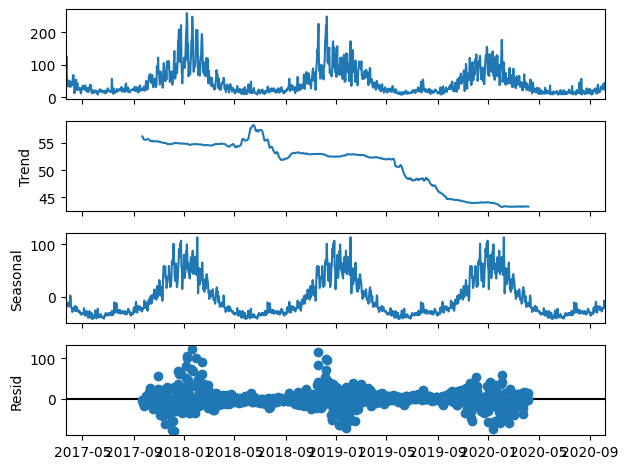

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sm_data, model='additive', period=368)
result.plot()
pyplot.show()

In [188]:
# sm_data['value'] = sm_data['value'] - result.trend - result.seasonal
# sm_data['value'] += abs(sm_data['value'].min())
# sm_data.dropna(inplace=True)

In [189]:
# from sktime.transformations.series.difference import Differencer
# transformer = Differencer(lags=1)
# sm_data = transformer.fit_transform(sm_data)

In [190]:
# # Seasonal differencing
# seasonal_period = 368  # Replace with your data's observed seasonal period
# sm_data = sm_data.diff(periods=seasonal_period).dropna()

In [191]:
from scipy import stats
# Box-Cox transformation (ensure series is positive)
boxcox_transformed_series, lambda_value = stats.boxcox(sm_data['value'].dropna() + 1)  # Add 1 to handle zero or negative values
sm_data['value'] = boxcox_transformed_series

In [192]:
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(sm_data, test_size=df_test.shape[0])

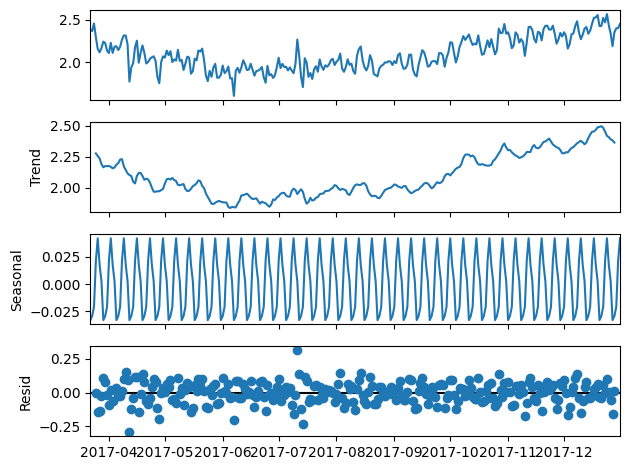

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train, model='additive')
result.plot()
pyplot.show()

In [194]:
kpss(sm_data)[1]

0.09097694653635413

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

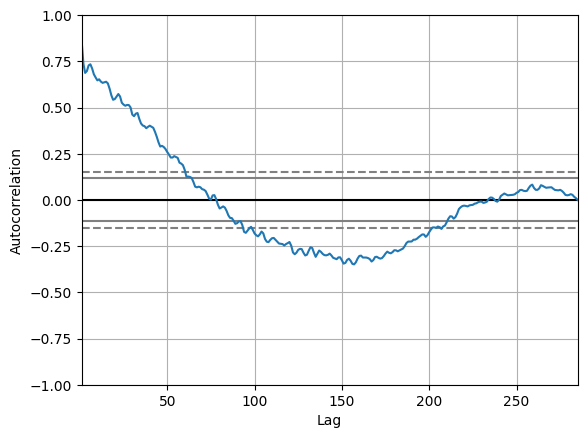

In [195]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train[:400])

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 400 must be < 142.

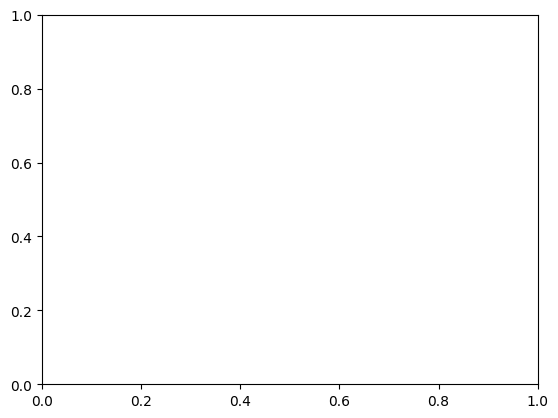

In [196]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=400)
pyplot.show()

<!-- there are several significant correlations, so it might be worth it to try periodicity based forecasting model. -->

In [197]:
from statsmodels.tsa.ar_model import AutoReg
params = AutoReg(train, lags = 160)
res = params.fit()
# res.summary()

ValueError: The model specification cannot be estimated. The model contains 161 regressors (1 trend, 0 seasonal, 160 lags) but after adjustment for hold_back and creation of the lags, there are only 125 data points available to estimate parameters.

In [198]:
# from statsmodels.tsa.ar_model import ar_select_order
# select = ar_select_order(train, 365, "aic", trend="ct", seasonal=True)
# print(select.ar_lags) # show all selected lags

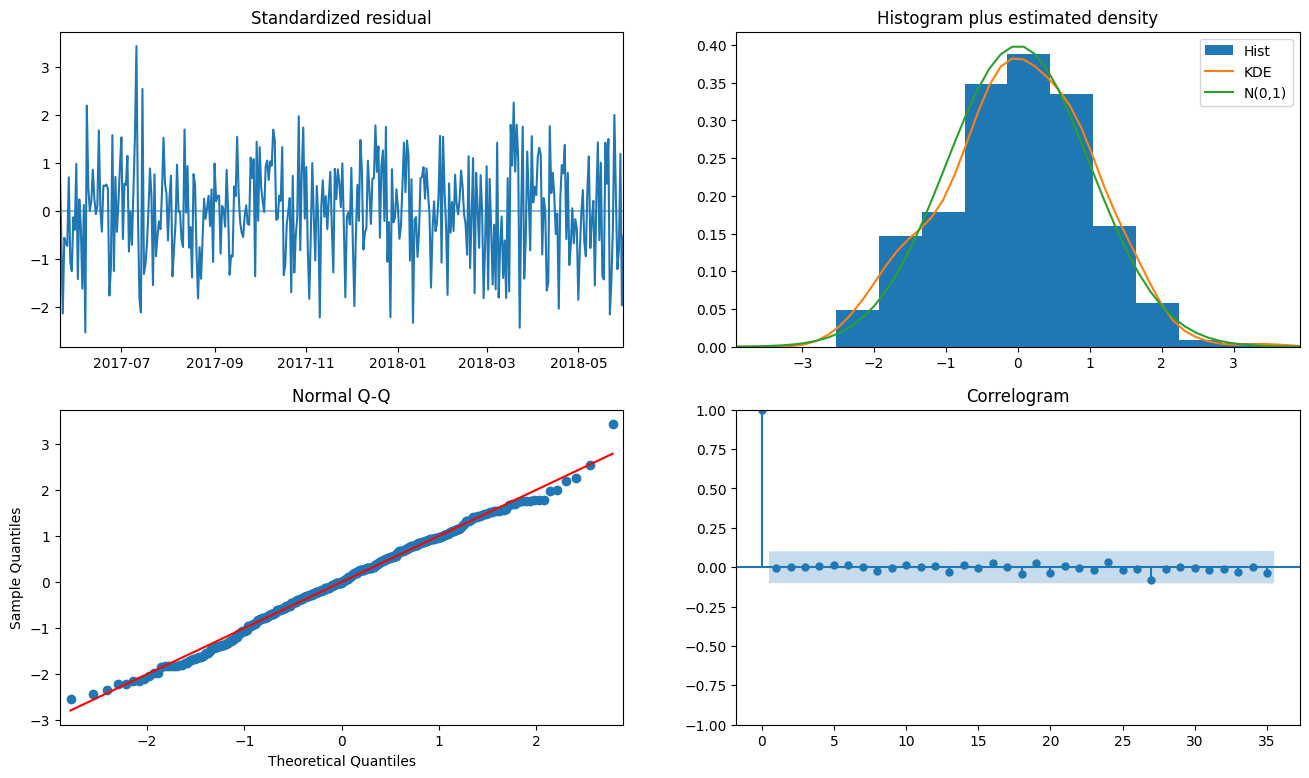

In [199]:
fig = pyplot.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=35)

In [221]:
params = AutoReg(train, lags = 20)
res = params.fit()
res.aic, res.bic, res.hqic

(-516.3302028619171, -437.5761466902202, -484.68802715660206)

In [222]:
# testing = pd.concat([train,test])
# ar35_predictions = []

# for i in range(len(train), len(train) + len(test)):
#     updated_res = res.apply(testing[:i])
#     ar35_predictions.append(updated_res.forecast(1).iloc[0])

# predictions = pd.DataFrame({
#     "AR": ar35_predictions,
#     "Actual": test['value'],
# })
# _, ax = pyplot.subplots()
# ax = predictions.plot(ax=ax)

# another try 
# testing = train.copy()
# ar35_predictions = []

# for i in range(len(train), len(train) + len(test)):
#     forecasted_value = updated_res.forecast(1).iloc[0]
#     ar35_predictions.append(forecasted_value)

#     next_date = testing.index[-1] + pd.Timedelta(days=1)
#     testing.loc[next_date] = forecasted_value

#     updated_res = res.apply(testing[:i])

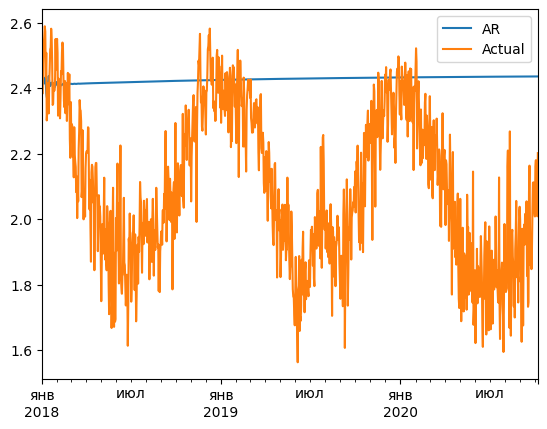

In [223]:
predictions = pd.DataFrame({
    "AR": res.forecast(len(test['value'])),
    "Actual": test['value'],
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

In [224]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

In [167]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(predictions['AR'], test['value']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.172


In [168]:
mape(predictions['AR'], test['value'])

6.730667353162695

<!-- inverse boxcox -->

In [169]:
boxcox_predictions = predictions['AR']

if lambda_value == 0:
    original_predictions = np.exp(boxcox_predictions)  # Use exponential if lambda = 0
else:
    original_predictions = np.power(lambda_value * boxcox_predictions + 1, 1 / lambda_value)

In [170]:
test_values = df_test.set_index("date_time")['value'].copy()
test_values.index = original_predictions.index

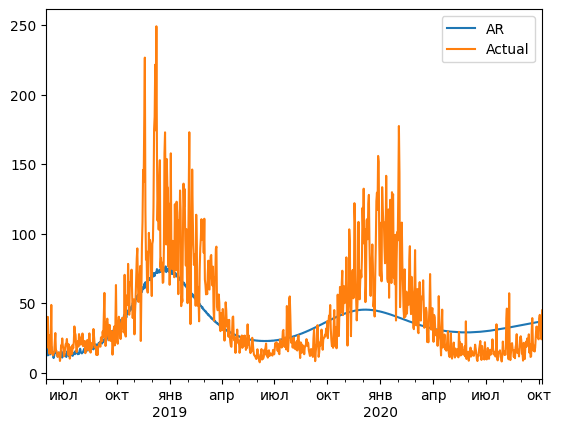

In [171]:
predictions = pd.DataFrame({
    "AR": original_predictions,
    "Actual": test_values,
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

In [172]:
a = original_predictions
b = test_values
mape(a, b), np.sqrt(mean_squared_error(a, b))

(48.306236938654514, 29.354233015572017)

In [173]:
def boxcox_to_orig(predictions, lambda_value):
    boxcox_predictions = predictions

    if lambda_value == 0:
        return np.exp(boxcox_predictions)  # Use exponential if lambda = 0
    else:
        return np.power(lambda_value * boxcox_predictions + 1, 1 / lambda_value)

In [141]:
t = df_train.set_index("date_time")
t.index = pd.to_datetime(t.index)

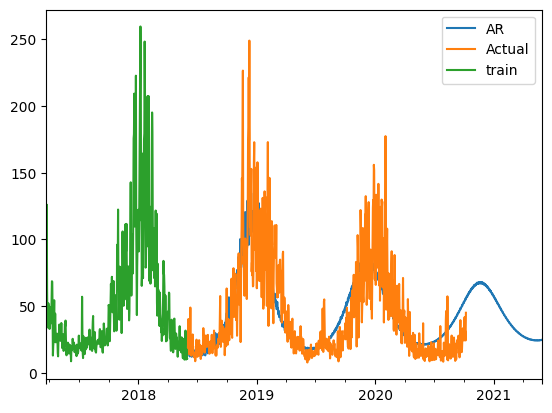

In [143]:
future_values = boxcox_to_orig(res.forecast(365*3), lambda_value)

predictions = pd.DataFrame({
    "AR": future_values,
    "Actual": test_values,
    "train": t['value']
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

<!-- ## LSTM wth 1d Conv -->

In [49]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

<!-- ## SARIMAX -->

In [ ]:
from itertools import product
import numpy as np

p = d = q = range(0, 3)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]  # Weekly seasonality

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(series, order=param, seasonal_order=seasonal_param).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f"Best SARIMA Params: {best_params}")


In [ ]:
# from tbats import TBATS

# # Fit TBATS model
# estimator = TBATS(seasonal_periods=[7, 365])  # e.g., weekly and yearly
# model = estimator.fit(train)
# forecast = model.forecast(steps=30)


KeyboardInterrupt: 

In [433]:
(29.63913192734023, 9.08976815816162)
(29.564047932270327, 9.12509253676859) # 25

(29.564047932270327, 9.12509253676859)

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align actual and predicted values for the OOT period
actual_oot = df_oot['value']
predicted_oot = average_prediction.loc[actual_oot.index]

# Calculate MAE
mae = mean_absolute_error(actual_oot, predicted_oot)

# Calculate MAPE (ensure no division by zero)
mape = (np.abs((actual_oot - predicted_oot) / actual_oot)).mean() * 100

# Calculate RMSE
rmse = mean_squared_error(actual_oot, predicted_oot, squared=False)

# Print results
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAE: 6.75
MAPE: 27.52%
RMSE: 10.09
